In [1]:
# from detection.custom_engine import train_model
from data_utils import get_datamoduels, get_transform
from datasets import KittiTorch
from custom_engine import reset_environment, train_model


reset_environment()

from configs import model_configs, epochs_list
from models import get_model

config = model_configs[0]


dataset = KittiTorch(root='../data', download=True, transform=get_transform())

train_dataset, val_dataset, test_dataset, train_dataloader, val_dataloader, test_dataloader = get_datamoduels(dataset, batch_size=config['batch_size'])

datasets = (train_dataset, val_dataset, test_dataset)
dataloaders = (train_dataloader, val_dataloader, test_dataloader)

Dataset size: 7481
Batch size: 4
Training set size: 5984
Validation set size: 748
Testing set size: 749


In [ ]:
model = get_model(config)

model = train_model(model, dataloaders, datasets, 1, config, learning_rate=0.001)

In [ ]:
model

/data/stanford/portalcut/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/stanford/portalcut/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/data/stanford/portalcut/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v

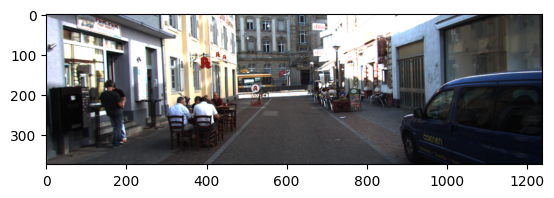

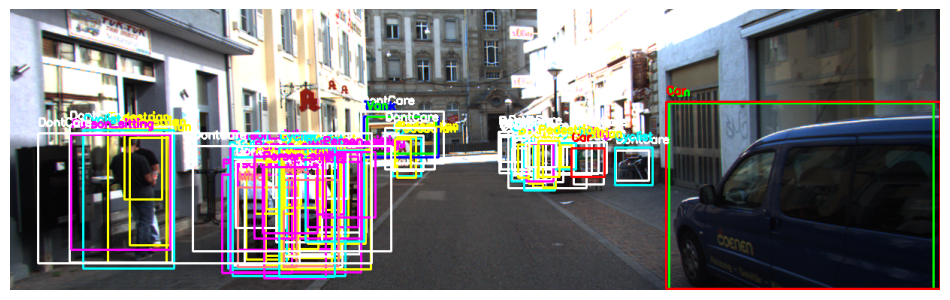

In [3]:
# Write the code that saves up the model from the internet and tests it
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import numpy as np

#clear cache in cuda
torch.cuda.empty_cache()

image = test_dataset[80][0]
# Load the model
model = get_model(config)
model.load_state_dict(torch.load('models/fasterrcnn_resnet50_fpn/final_model.pth'))

# # Ensure your model is on the GPU
model = model.to('cuda')

# Move the input tensor to the GPU
input_tensor = image.unsqueeze(0).to('cuda')


model.eval()

# Disable gradient computation during inference
with torch.no_grad():
    predictions = model(input_tensor)


import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_with_boxes(image, boxes, labels, label_names):
    # Convert tensor image to numpy array
    image = image.cpu().numpy().transpose((1, 2, 0))
    # Scale the image's pixel values to [0, 255]
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
    # Convert the image to CPU and NumPy format for plotting


    # Define colors for different classes
    colors = {
        'Car': (255, 0, 0), 'Van': (0, 255, 0), 'Truck': (0, 0, 255),
        'Pedestrian': (255, 255, 0), 'Person_sitting': (255, 0, 255), 'Cyclist': (0, 255, 255),
        'Tram': (127, 127, 255), 'Misc': (255, 127, 127), "Don'tCare": (127, 127, 127)
    }

    # Draw boxes and labels
    for box, label in zip(boxes, labels):
        box = box.cpu().numpy().astype(int)
        label = int(label.cpu())
        box = box.astype(int)
        label_text = label_names[label]
        color = colors.get(label_text, (255, 255, 255))

        # Draw rectangle
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)

        # Put label
        cv2.putText(image, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Define label names based on your dataset specifics
label_names = ['Background', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

# Sample call to the function

target = predictions[0]
# image = dataset[0][0]
plt.imshow(image.permute(1, 2, 0))
# This assumes `image` is a tensor from the dataset, `boxes` is a tensor of bounding boxes, and `labels` is a tensor of label indices
visualize_image_with_boxes(image, target['boxes'], target['labels'], label_names)
